# Application de la fonction de corrélation croisée correlate2D sur une image terrain

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
from matplotlib.pyplot import figure
import matplotlib.patches as patches

from scipy import signal
from scipy import misc

import cv2

import warnings
warnings.filterwarnings("ignore")

In [2]:
band1 = np.loadtxt("band1.txt")
band2 = np.loadtxt("band2.txt")

### BAND 1 - Relevé topographique 

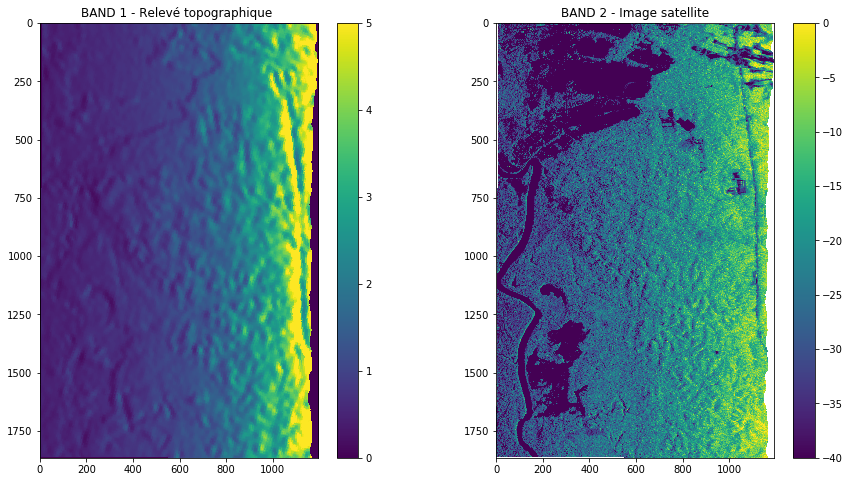

In [3]:
fig,ax = plt.subplots(1,2, figsize=(15,8))

im1 = ax[0].imshow(band1, vmin = 0, vmax = 5)
ax[0].set_title("BAND 1 - Relevé topographique ")
fig.colorbar(im1,ax=ax[0])

im2 = ax[1].imshow(10*np.log(band2),vmin=-40,vmax=0)
ax[1].set_title("BAND 2 - Image satellite")
fig.colorbar(im2,ax=ax[1])

plt.show()

## ANALYSE PAR BLOC - DECALAGE D'IMAGES

Explication de l'algo -- on veut un champ de vecteurs

In [4]:
def decalageBloc(original, template):
    orig = np.copy(original)  #prévenir pbs de pointeurs python
    temp = np.copy(template)

    orig -= original.mean()
    temp -= template.mean()

    corr = signal.correlate2d(orig, temp, boundary='symm', mode='same')
    y, x = np.unravel_index(np.argmax(corr), corr.shape)  # find the match
    
    return orig, temp, corr, x, y

In [67]:
def displayImg(original,template,corr,x,y):
    fig, (ax_orig, ax_template, ax_corr) = plt.subplots(1, 3,figsize=(10, 20))
    ax_orig.imshow(original, cmap='gray')
    ax_orig.set_title('Original')
    ax_orig.set_axis_off()
    
    ax_template.imshow(template, cmap='gray')
    ax_template.set_title('Template')
    ax_template.set_axis_off()
    
    ax_corr.imshow(corr, cmap='gray')
    ax_corr.set_title('Cross-correlation')
    ax_corr.set_axis_off()
    
    ax_orig.plot(x, y, 'ro')
    fig.show()
    
    
    print("(x,y) = ("+str(x)+','+str(y)+')' )

    
#     figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
#     plt.imshow(original)
#     plt.plot(x, y, 'ro')

### Floutage gaussien

In [6]:
def gaussianFilter(im1,factor):
    kernel = np.ones((factor,factor),np.float32)/(factor**2)
    target = cv2.filter2D(im1,-1,kernel)
    return target

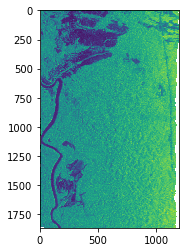

In [7]:
plt.imshow(gaussianFilter(10*np.log(band2),1))

### Test pour un bloc 

In [8]:
def selection(img,x0,x1,y0,y1):
    h = abs(x0 - x1)
    w = abs(y0 - y1)
    fig,ax = plt.subplots(1, 2,figsize=(16, 8))
    ax[0].imshow(img)
    rect = patches.Rectangle((y0,x0),w,h,linewidth=1,edgecolor='r',facecolor='none')
    ax[0].add_patch(rect)
    ax[0].set_title("Image originale")
    ax[1].imshow(img[x0:x0+h,y0:y0+w])
    ax[1].set_title("Selection")
    plt.show()
    return img[x0:x0+h,y0:y0+w]


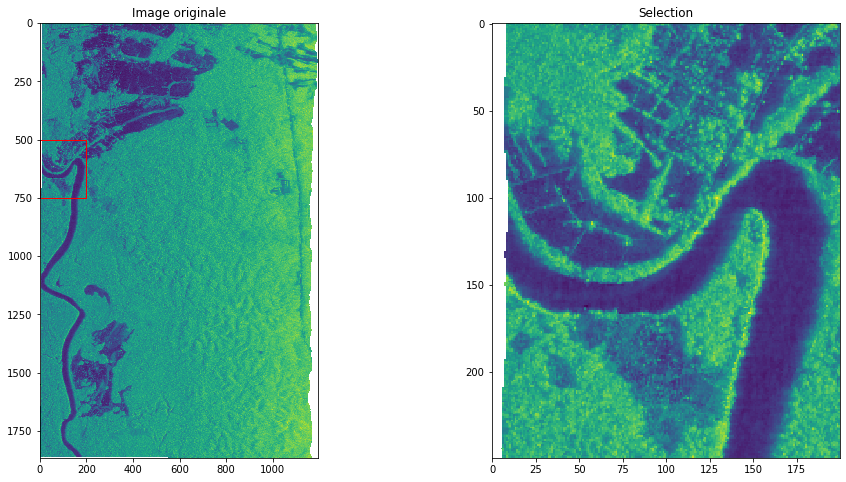

In [9]:
template = selection(10*np.log(band2),500,750,0,200)

In [10]:

original2 = np.copy(band2[1000:1250,600:850])
original1 = np.copy(band1[1000:1250,600:850])

template2 = np.copy(original2[50:200,50:200])
template1 = np.copy(original1[50:200,50:200])

In [11]:
def testBloc(original, template):
    orig,temp,corr,x,y = decalageBloc(original,template)
    displayImg(orig,temp,corr,x,y)

(x,y) = (119,110)


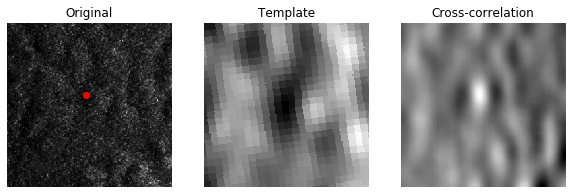

In [61]:
testBloc(original2,template1)

### Rognage de l'image de départ 

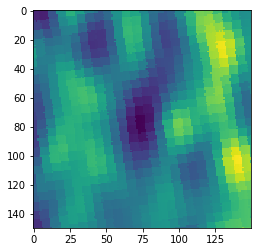

In [59]:
plt.imshow(template1)

In [24]:
bandr1 = np.copy(band1[750:1750,400:1000])
bandr2 = np.copy(band2[750:1750,400:1000])

In [26]:
n,m = np.shape(bandr2)
print(n,m)

nbBlocks = 10
blocksize = (n//nbBlocks,m//nbBlocks)

print(blocksize)

1000 600
(100, 60)


### PARCOURS PAR BLOC

In [71]:
def decalageImg(bandr2,bandr1):
    tabx = []
    taby = []
        
    for i in range(3):
        for j in range(3):
            band2Block = np.copy(bandr2[i*200:(i*200)+199,j*200:(j*200)+199])
            band1Block = np.copy(bandr1[i*200:(i*200)+199,j*200:(j*200)+199])
            templateBlock = np.copy(band1Block[10:190,10:190])
                        
            orig,temp,corr,x,y = decalageBloc(band2Block,templateBlock)
            #displayImg(orig,temp,corr,x,y)
            xm = x-100
            ym = y-100
            tabx.append(xm)
            taby.append(ym)
    return tabx,taby

In [ ]:
# # tabx,taby = decalageImg(gaussianFilter(bandr2,4),bandr1)
rez = []
for i in range(1,5):

    tabx,taby = decalageImg(gaussianFilter(bandr2,i),bandr1)
    rez.append(countCorrect(tabx,taby,20))
 
plt.plot(rez)
plt.show()

### Tendance : Ce graphe a une facheuse tendance

In [54]:
def countCorrect(tabx,taby,seuil, verbose=False):
    count = 0
    for i in range(len(tabx)):
        if verbose :
            print("Décalage du block " +str(i)+ " : %.2f" % (np.sqrt(tabx[i]**2 + taby[i]**2)*5) + " m.")
        if np.sqrt(tabx[i]**2 + taby[i]**2) < seuil:  #distance inférieure à 50 px (c'est beaucoup)
            count +=1
    if verbose:
        print(str(count)+" corrects sur "+ str(len(tabx)) + " avec une marge de " + str(seuil * 5) +" m.")
    return count 

In [55]:
print(countCorrect(tabx,taby,20,True))


Décalage du block 0 : 69.64 m.
Décalage du block 1 : 87.32 m.
Décalage du block 2 : 81.39 m.
Décalage du block 3 : 85.44 m.
Décalage du block 4 : 69.64 m.
Décalage du block 5 : 71.59 m.
Décalage du block 6 : 86.02 m.
Décalage du block 7 : 85.44 m.
Décalage du block 8 : 73.82 m.
9 corrects sur 9 avec une marge de 100 m.
9


A faire : Tester la superposition manuelle de la fonction de normalisation sur l'image radar avec le décalage que trouve **decalageImg**. Sert à vérifier si le décalage trouvée sur les blocs où la fontion marche est correct.